In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F

from tqdm import tqdm

torch_seed = 37
t.manual_seed(torch_seed)

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])

In [3]:
data_root = 'imagenet'

imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
toImage = v2.ToPILImage()

test_size = 64
train_size = test_size
dataloader = t.utils.data.DataLoader(dataset=imagenet_val_inference, batch_size=test_size, shuffle = True)

train_images, _ = next(iter(dataloader))
test_images, _ = next(iter(dataloader))
train_images = train_images.to(device)
test_images = test_images.to(device)

In [4]:
from utils.diffeo_container import sparse_diffeo_container

sparse_diffeos = sparse_diffeo_container(224, 224)
sparse_diffeos.sparse_AB_append(2,2,1,0.5,1)
sparse_diffeos.get_all_grid()
sparse_diffeos.to(device)

In [5]:
from utils.inverse_diffeo import find_param_inverse
from utils.diffeo_container import sparse_diffeo_container

AB_original = t.cat([t.stack(sparse_diffeos.A), t.stack(sparse_diffeos.B)])
inv_AB, inv_loss_hist, AB_mag = find_param_inverse(AB_original, extra_freq_scaling = 10, device = device)
inv_AB = inv_AB.cpu()
inv_diffeo_224 = sparse_diffeo_container(224, 224, A = [inv_AB[0]], B = [inv_AB[1]])
inv_diffeo_224.get_all_grid()
inv_diffeo_112 = sparse_diffeo_container(112, 112, A = [inv_AB[0]], B = [inv_AB[1]])
inv_diffeo_112.get_all_grid()

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 500/500 [00:03<00:00, 140.20it/s]


/tmp/ipykernel_3270544/2124604803.py:17: RuntimeWarning: divide by zero encountered in log10
  axes[2].matshow(np.log10(inv_AB[0,0].cpu().abs()), vmin = -7, vmax = -1)
/tmp/ipykernel_3270544/2124604803.py:19: RuntimeWarning: divide by zero encountered in log10
  cb = axes[3].matshow(np.log10(inv_AB[1,0].cpu().abs()), vmin = -7, vmax = -1)


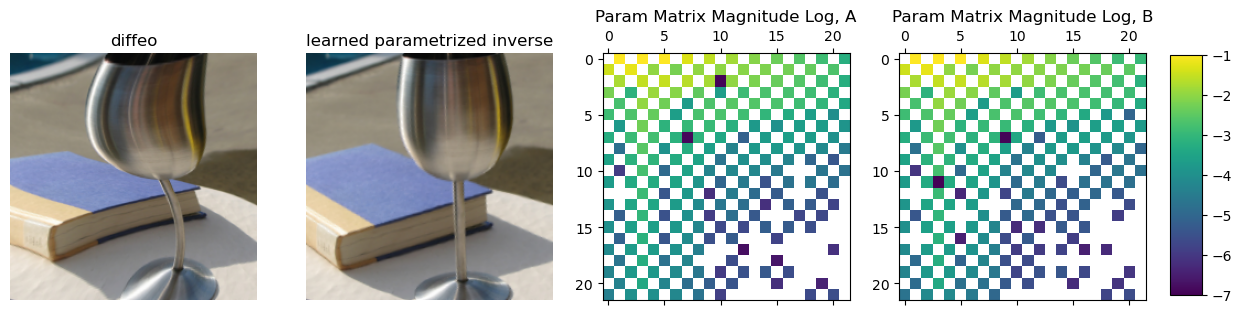

In [6]:
fav_pic_index = 28621
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]

fig, axes = plt.subplots(1, 4, figsize = (4 * 4 ,4))
axes[0].imshow(toImage(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0].squeeze()))
axes[0].set_title('diffeo')
axes[1].imshow(toImage(F.grid_sample(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0], inv_diffeo_224[0].to(device), align_corners = True).squeeze()))
axes[1].set_title('learned parametrized inverse')

axes[2].matshow(np.log10(inv_AB[0,0].cpu().abs()), vmin = -7, vmax = -1)
axes[2].set_title('Param Matrix Magnitude Log, A')
cb = axes[3].matshow(np.log10(inv_AB[1,0].cpu().abs()), vmin = -7, vmax = -1)
axes[3].set_title('Param Matrix Magnitude Log, B')

fig.subplots_adjust(right=0.835)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(cb, cax=cbar_ax)
[ax.axis('off') for i, ax in enumerate(axes) if i<2];

In [7]:
from utils.get_model_activation import get_flatten_children, retrieve_layer_activation

eval_diffeo = sparse_diffeo_container(224, 224, diffeos = [sparse_diffeos[0].expand(train_size, -1, -1, -1)])
eval_diffeo.to(device)

eval_inv_diffeo = sparse_diffeo_container(112, 112, diffeos = [inv_diffeo_112[0].expand(train_size, -1, -1, -1)])
eval_inv_diffeo.to(device)

activation_ref, result = retrieve_layer_activation(ENV2, train_images, [5])
activation_dis, result = retrieve_layer_activation(ENV2, eval_diffeo(train_images, in_inference = True), [5])

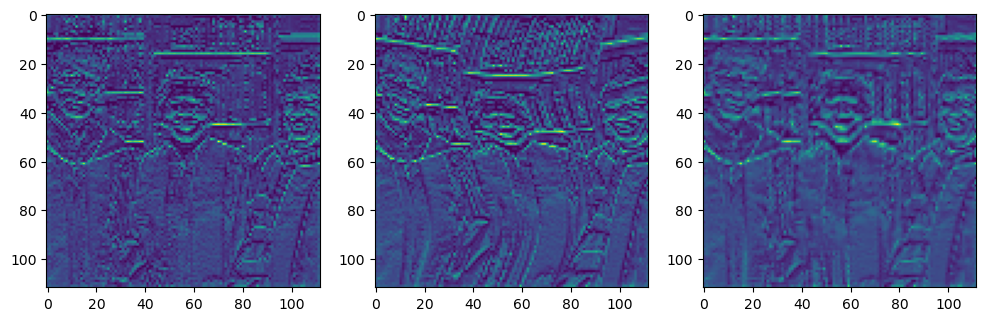

In [8]:
activation_inv = {}
activation_inv['5'] = eval_inv_diffeo(activation_dis['5'], in_inference=True)


img = 37
channel = 20
fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(activation_ref['5'][img,channel].cpu())
axes[1].imshow(activation_dis['5'][img,channel].cpu())
axes[2].imshow(activation_inv['5'][img,channel].cpu())

In [9]:
from utils.inverse_diffeo import find_img_inverse

inv_AB_2, inv_loss_hist_2, AB_mag_2 = find_img_inverse(activation_dis['5'], activation_ref['5'], AB_original, extra_freq_scaling = 10, device = device)
inv_AB_2 = inv_AB_2.cpu()
inv_diffeo_2 = sparse_diffeo_container(112, 112, A = [inv_AB_2[0]], B = [inv_AB_2[1]])
inv_diffeo_2.get_all_grid()


100%|██████████| 500/500 [00:03<00:00, 154.23it/s]


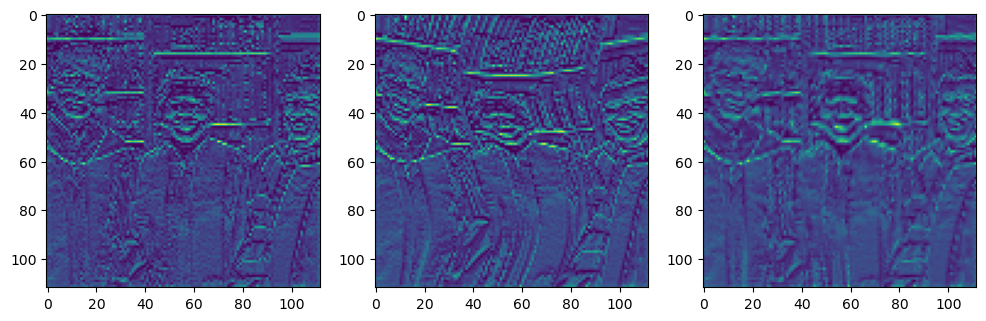

In [10]:
eval_inv_diffeo_2 = sparse_diffeo_container(112, 112, diffeos = [inv_diffeo_2[0].expand(train_size, -1, -1, -1)])
eval_inv_diffeo_2.to(device)

activation_inv_2 = {}
activation_inv_2['5'] = eval_inv_diffeo_2(activation_dis['5'], in_inference=True)



fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(activation_ref['5'][img,channel].cpu())
axes[1].imshow(activation_dis['5'][img,channel].cpu())
axes[2].imshow(activation_inv_2['5'][img,channel].cpu())

In [50]:
class DeNoiser(t.nn.Module):
    def __init__(self, channel_num, kernal_size, non_linear_fn, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(channel_num, channel_num, kernel_size = kernal_size, groups=channel_num, **kwargs)
        self.conv2 = nn.Conv2d(channel_num, channel_num, kernel_size = kernal_size, groups=channel_num, **kwargs)
        self.conv3 = nn.Conv2d(channel_num, channel_num, kernel_size = kernal_size, groups=channel_num, **kwargs)
        self.conv4 = nn.Conv2d(channel_num, channel_num, kernel_size = kernal_size, groups=channel_num, **kwargs)
        self.conv5 = nn.Conv2d(channel_num, channel_num, kernel_size = kernal_size, groups=channel_num, **kwargs)
        self.conv6 = nn.Conv2d(channel_num, channel_num, kernel_size = kernal_size, groups=channel_num, **kwargs)
        self.non_linearity = non_linear_fn
    def forward(self, inputs):
        level_1 = self.non_linearity(self.conv1(inputs))
        level_1 = self.non_linearity(self.conv2(level_1))
        level_1 = self.non_linearity(self.conv3(level_1))
        output = inputs + 0.1 * level_1
        level_2 = self.non_linearity(self.conv4(output))
        level_2 = self.non_linearity(self.conv5(level_2))
        level_2 = self.non_linearity(self.conv6(level_2))
        return (output + 0.1 * level_2)

denoiser = DeNoiser(24, 5, nn.GELU(), padding = 'same').to(device)

In [51]:
loss_hist = []
num_epochs = 5000
optimizer = t.optim.SGD(denoiser.parameters(), lr = 1e-1)

data = activation_inv['5'].detach()
ref = activation_ref['5'].detach()

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output = denoiser(data)
    loss = nn.MSELoss()(ref, output)
    loss.backward()
    optimizer.step()
    if (epoch) % 50 == 0:
      loss_hist.append(loss.item())

100%|██████████| 5000/5000 [03:02<00:00, 27.41it/s]


In [52]:
loss_hist

[12.689410209655762,
 12.680055618286133,
 12.673709869384766,
 12.667688369750977,
 12.663207054138184,
 12.659395217895508,
 12.656100273132324,
 12.653020858764648,
 12.6499605178833,
 12.646628379821777,
 12.642900466918945,
 12.63870906829834,
 12.633979797363281,
 12.628732681274414,
 12.623350143432617,
 12.618383407592773,
 12.614079475402832,
 12.610376358032227,
 12.607104301452637,
 12.604125022888184,
 12.60133171081543,
 12.59865665435791,
 12.596051216125488,
 12.59354019165039,
 12.591146469116211,
 12.588875770568848,
 12.5867280960083,
 12.584681510925293,
 12.58267879486084,
 12.580434799194336,
 12.573707580566406,
 12.561129570007324,
 12.559123039245605,
 12.557046890258789,
 12.554842948913574,
 12.552443504333496,
 12.549800872802734,
 12.5469970703125,
 12.544352531433105,
 12.542135238647461,
 12.540266036987305,
 12.538543701171875,
 12.536861419677734,
 12.535196304321289,
 12.533543586730957,
 12.531893730163574,
 12.530255317687988,
 12.528623580932617,
 12

In [44]:
with t.no_grad(): 
    print(nn.MSELoss()(ref, data))

tensor(12.6809, device='cuda:0')


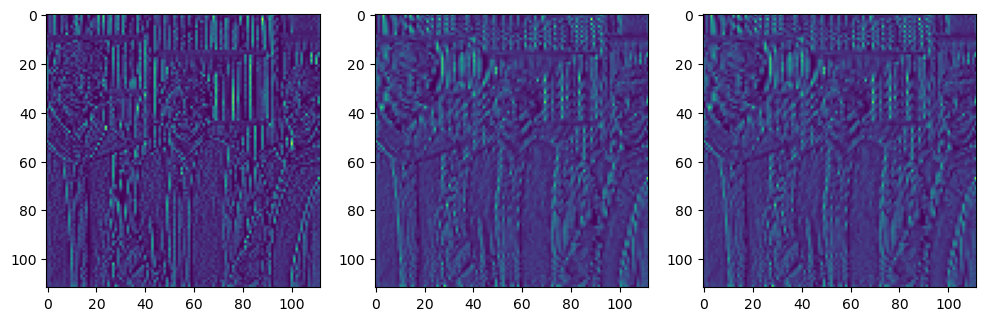

In [49]:
img = 37
channel = 0

with t.no_grad(): demo_img = denoiser(activation_inv['5']).detach()

fig, axes = plt.subplots(1, 3, figsize = (12,4))
axes[0].imshow(activation_ref['5'][img,channel].cpu())
axes[1].imshow(activation_inv['5'][img,channel].cpu())
axes[2].imshow(demo_img[img, channel].cpu())
